In [3]:
import os
import json
import copy
import random
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import rankdata
import tensorflow_datasets as tfds

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터 import

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=False,
    with_info=True,
)

In [6]:
def extract_dataset(sample):
    image = sample['image']
    label = sample['label']
    return image, label

def extract_image(sample):
    return sample['image']

def extract_label(sample):
    return sample['label']

def extract_bbox(sample):
    bboxes = sample['objects']['bbox']
    return bboxes

In [7]:
def make_data_set(ds, data_num):
    ds_random = ds.take(data_num)
    
    ds_dataset = ds_random.map(extract_dataset)
    ds_bbox = ds_random.map(extract_bbox)
    
    ds_image = []
    ds_box = []
    for sample1, sample2 in zip(ds_dataset, ds_bbox):
        ds_img = sample1[0]
        bbox = np.array(sample2).tolist()[0]
        ds_image.append(ds_img)
        ds_box.append(bbox)
        
    return ds_dataset, ds_image, ds_box

In [8]:
ds_dataset, ds_image, ds_box = make_data_set(ds_train, 480)

## 주요 함수 선언

In [9]:
num_classes = ds_info.features["label"].num_classes

In [10]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [11]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [12]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [13]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        j = batch_size
        while j != i and j != batch_size :
            j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
            
        image_a = image[i]
        label_a = label[i]
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [14]:
def apply_normalize_on_dataset(ds, batch_size=16, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.map(
        onehot,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if with_mixup:
        ds_mixup = ds.map(
            mixup,
            num_parallel_calls=2
        )
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
def normal_cam(dataset, cam_model, class_weights, batch_size=16, data_count=3200):
    cam_image = []
    for ima_num in range(0, data_count, batch_size):
        width = []
        height = []
        
        batch_data = dataset.skip(ima_num).take(batch_size)
        
        for raw_sample in batch_data:
            width.append(raw_sample[0].shape[1])
            height.append(raw_sample[0].shape[0])
            
        norm_data = apply_normalize_on_dataset(batch_data, with_mixup=False)
        
        for skip_num in range(batch_size):
            for sample in norm_data.skip(skip_num).take(1):
                img_tensor = sample[0]
                class_idx = sample[1]
                
                for k, (img, idx) in enumerate(zip(img_tensor, class_idx)):
                    conv_outputs, predictions = cam_model(tf.expand_dims(img, 0))
                    conv_outputs = conv_outputs[0, :, :, :]
                    
                    idx = np.array(idx).argmax()
                    
                    single_cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
                    for i, w in enumerate(class_weights[:, idx]):
                        single_cam_image += w * conv_outputs[:, :, i]
                    
                    single_cam_image /= np.max(single_cam_image)
                    single_cam_image = single_cam_image.numpy()
                    single_cam_image = cv2.resize(single_cam_image, (width[k], height[k]))
                    cam_image.append(single_cam_image)
    return cam_image

In [16]:
def normal_grad_cam(dataset, cam_model, batch_size=16, data_count=3200):
    cam_image = []
    for ima_num in range(0, data_count, batch_size):
        width = []
        height = []
        
        batch_data = dataset.skip(ima_num).take(batch_size)
        
        for raw_sample in batch_data:
            width.append(raw_sample[0].shape[1])
            height.append(raw_sample[0].shape[0])
            
        norm_data = apply_normalize_on_dataset(batch_data, with_mixup=False)
        
        for skip_num in range(batch_size):
            for sample in norm_data.skip(skip_num).take(1):
                img_tensor = sample[0]
                class_idx = sample[1]
                
                for k, (img, idx) in enumerate(zip(img_tensor, class_idx)):
                    with tf.GradientTape() as tape:
                        conv_output, pred = cam_model(tf.expand_dims(img, 0))
                        
                        idx = np.array(idx).argmax()
                        loss = pred[:, idx]
                        output = conv_output[0]
                        grad_val = tape.gradient(loss, conv_output)[0]
                        
                    weights = np.mean(grad_val, axis=(0, 1))
                    single_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
                    
                    for i, w in enumerate(weights):
                        single_cam_image += w * output[:, :, i]
                    
                    single_cam_image = tf.math.maximum(0, single_cam_image)
                    single_cam_image /= np.max(single_cam_image)
                    single_cam_image = single_cam_image.numpy()
                    single_cam_image = cv2.resize(single_cam_image, (width[k], height[k]))
                    cam_image.append(single_cam_image)
    return cam_image

In [17]:
def generate_cam(dataset, cam_model, class_weights, batch_size=16, data_count=480):
    cam_image = normal_cam(dataset, cam_model, class_weights, batch_size, data_count)
    return cam_image

In [18]:
def generate_grad_cam(dataset, cam_model, batch_size=16, data_count=480):
    cam_image = normal_grad_cam(dataset, cam_model, batch_size, data_count)
    return cam_image

In [19]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [20]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),
        rect[:,0].min()/float(image.shape[1]),
        rect[:,1].max()/float(image.shape[0]),
        rect[:,0].max()/float(image.shape[1])
    ]
    return bbox

In [21]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [22]:
def altinative_iou(cam_image, image, bbox):
    cam_rect = []
    cam_bbox = []
    return_list = []
    
    for single_cam in cam_image:
        single_cam_rect = get_bbox(single_cam)
        cam_rect.append(single_cam_rect)
    
    for single_rect, single_image in zip(cam_rect, image):
        single_cam_bbox = rect_to_minmax(single_rect, single_image)
        cam_bbox.append(single_cam_bbox)
    
    for single_cam_box, single_real_box in zip(cam_bbox, bbox):
        single_iou = get_iou(single_cam_box, single_real_box)
        return_list.append(single_iou)
        
    print('Aver IoU is : ', sum(return_list) / len(return_list))
    print('Max IoU is : ', max(return_list), 'and index is : ', return_list.index(max(return_list)))
    
    return return_list

In [23]:
def plot_iou_distribution(iou_list):
    normalized_iou = (iou_list - np.min(iou_list)) / (np.max(iou_list) - np.min(iou_list))
    
    plt.figure(figsize=(8, 6))
    
    mean, std = np.mean(normalized_iou), np.std(normalized_iou)
    
    xmin, xmax = 0, 1
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    plt.title('IoU Distribution with Normal Distribution Fit', fontsize=14)
    plt.xlabel('Normalized IoU', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(True)
    plt.show()

In [24]:
def visualize_cam_on_image(image, cam_image, rato):
    merged_image = None
    a = rato
    b = 1.0 - a
    merged_image = cv2.addWeighted(cam_image, a, image, b, 0)
    return merged_image

In [25]:
def visualize_random(cam_image, image, file_path, data_count=3200):
    choice_list = [random.randint(0, data_count) for value in range(0, 10)]
    
    for i in choice_list:
        origin_image = image[i].numpy().astype(np.uint8)
        cam_image_3channel = np.stack([cam_image[i]*255]*3, axis=-1).astype(np.uint8)
        blended_image = visualize_cam_on_image(cam_image_3channel, origin_image, 0.3)
        save_path = file_path+f"image_{i}.jpg"
        cv2.imwrite(save_path, blended_image)

## 모델 추론 및 평가

In [26]:
model_path = os.getenv('HOME')+'/aiffel/model_weight/GD03/cam_model_resnet50.keras'
model = tf.keras.models.load_model(model_path)

In [27]:
cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])

In [28]:
class_weights = model.layers[-1].get_weights()[0]

In [29]:
finaly_cam = generate_cam(ds_dataset, cam_model, class_weights, 16, 32)

In [30]:
finaly_grad_cam = generate_grad_cam(ds_dataset, cam_model, 16, 32)

In [31]:
IoU_cam_list = altinative_iou(finaly_cam, ds_image, ds_box)

Aver IoU is :  0.6037101143918526
Max IoU is :  0.9088348469345162 and index is :  3


In [32]:
IoU_grad_list = altinative_iou(finaly_grad_cam, ds_image, ds_box)

Aver IoU is :  0.5623013546050362
Max IoU is :  0.8927204365087825 and index is :  3


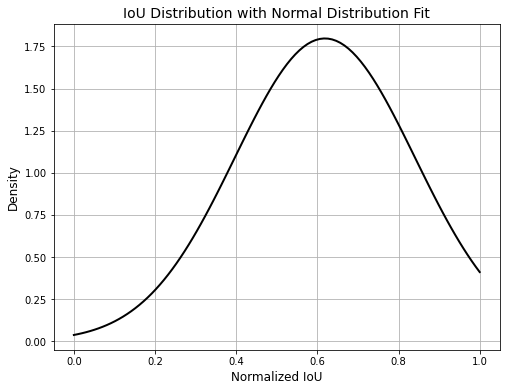

In [33]:
plot_iou_distribution(IoU_cam_list)

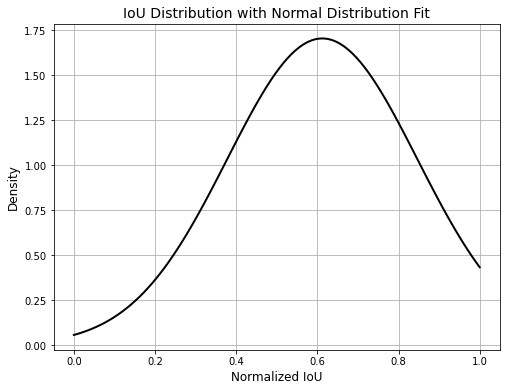

In [34]:
plot_iou_distribution(IoU_grad_list)

In [35]:
visualize_random(finaly_cam, ds_image, 'images/classic/imagenet_cam', 32)

In [36]:
visualize_random(finaly_grad_cam, ds_image, 'images/classic/imagenet_grad', 32)

## 본 ipynb 파일은
## classic fine-turning 모델의 cam-grad-cam 시험 파일임
## 사용 모델은 Resnet_50이고 가중치는 imagenet